# API notebook

This file is the readable version of the code that will be put into the api and possible seperate files as it grows. Everything below was coded for the purpose of allowing us to send an API a base64 image and use a series of ML algorthms to detect and manipulate objects within the image. Currently for this submission I am focusing on a cup object on the table although the model could be trained with other objects.

This file goes along with a h5 file which is the model used that has been trained, as well as a config file. The system config file outline is below in its own box however the best way to understand this is to look at where it is used.

The MRCNN library is used to visualise and run detection on the image.

# Imports

In [1]:
# FILE NEEDS MODULARISED

import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from flask import Flask, request, jsonify
from PIL import Image
from keras.backend import clear_session
import datetime as datetime

#----------------------------
# RCNN IMPORTS
#----------------------------

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import cups as cup

app = Flask(__name__)

sys_config=json.load(open("config.json", 'r'))

Using TensorFlow backend.


# Config file

Values have been removed from this block for privacy

In [ ]:
{
    "api":{
        "base uri":"/api"
    },
    "model directory":"-",
    "weights path" : "-/.h5",
    "device":"/cpu:0",
    "mode":"inference",
    "cup directory":"-"
}

# Image decoder

In order to support as many image types as possible, the API will only accept bas64 encoded images. base64 is an open file type and can therefore be converter easily from and to many other types. The file type as outlined in the documentation will be png for the final PoC however as the api will be open sourced at the end, base64 was the best way to future proof the solution.

In [2]:
import base64
import skimage.io

# This is requred to change base64 into a numpy ndarray

def decode(base64_string):
    if isinstance(base64_string, bytes):
        base64_string = base64_string.decode("utf-8")
    imgdata = base64.b64decode(base64_string)
    img = skimage.io.imread(imgdata, plugin='imageio')
    return img

# Api Config

These blocks are used for configurations local to the api that are required. 

The first is a get_ax() method. This standardises all graphs used and may be removed in future iterations. Inference config allows us to overwrite some values from the model config to suit the system the api is deployed on. create model is used to do just that: create the model we will use. This makes the h5 file into a dataset we can quickly call to

In [3]:
def get_ax(rows=1, cols=1, size=16):
    #This fn essentially allows a base size for graphs below
    #Common thing i've seen in notebooks with matplotlib
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
config = cup.CupConfig()

class InferenceConfig(config.__class__):
    # Make sure we only run detection 1 at a time
    # This value may be increased when moved to cloud
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.96
config = InferenceConfig()


def create_model():
    with tf.device(sys_config["device"]):
        clear_session()
        global model
        model = modellib.MaskRCNN(mode=sys_config["mode"], model_dir=sys_config["model directory"],
                                  config=config)
    try:
        print("Loading weights ", sys_config["weights path"])
        model.load_weights(sys_config["weights path"], by_name=True)
    except:
        print("Weights file unable to be loaded".format(error))

# Final return

This method is the final return values for the api. This calls to all other methods and compiles their returns into an easily digestible json dump.

In [5]:
#rois: [N, (y1, x1, y2, x2)] detection bounding boxes
def final_ret(image, roi):
    img=image[roi[0]:roi[2], roi[1]:roi[3]]
    centre = find_box_center(roi, image)
    plt.imshow(img)
    filename="detect_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
    plt.savefig(filename)
    return json.dumps({"image":img.tolist(), "centre": centre, "filename":filename})

# Find Centre

In order to accurately recreate the image in 3D i will need to know the relative and true coordinates of the object in screen space. This method finds the centrepoint of the region of interest and returns a list of all 4 values. We don't need to worry about different x/y sizes of the whole image because it is normalised to 1024x1024 when decoded by the rcnn.

In [6]:
def find_box_center(roi, image):
    true_y = (roi[0]+roi[2])/2
    true_x = (roi[1]+roi[3])/2
    rel_roi = []
    for i in roi:
        #The shape of the image is normalised to square so we don't need to
        #worry about different x and y shapes
        rel_roi.append((i/image.shape[0])*100)
    rel_y = np.round((rel_roi[0]+rel_roi[2])/2, 2)
    rel_x = np.round((rel_roi[1]+rel_roi[3])/2, 2)

    return ([true_y, true_x, rel_y, rel_x])

# Detect and crop boxes

So i need to crop out the object to pass to the next model that will give me the rotation and depth. I could have just cropped the detected mask of the object but i found that just removing the refined region of interest would work better as it gives a more consistent view of the full object. This essentially cuts down on mistakes made by the model giving me a more accurate system overall.

The method calls the detection from the RCNN model and uses this to generate the RoIs to pass through the system.

In [7]:
def detect_boxes_and_crop(image):
    create_model()
    prediction = model.detect([image])[0]
    imgs=[]
    for roi in prediction['rois']:
        plt.axis('off')
        box_ret = final_ret(image, roi)
        imgs.append(box_ret)
    return imgs

# The main route

This is the route that will be hit when someone calls to the API. it calls both the decode and the detect methods and sets everything in motion. 

This will be changed in the final version of the system.

In [8]:
@app.route(sys_config['api']['base uri'], methods=['POST'])
def detect_cup_in_img():
    if not request.json:
        abort(400)
    image = decode(request.json['image'])
    cropped_images=detect_boxes_and_crop(image)
    return jsonify(cropped_images), 200

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  C:\Users\AdamG\OneDrive\Documents\Projects\Uni\FYP\API\logs\initial_cups\mask_rcnn_cup_0017.h5


127.0.0.1 - - [27/Nov/2018 18:04:09] "POST /api HTTP/1.1" 200 -


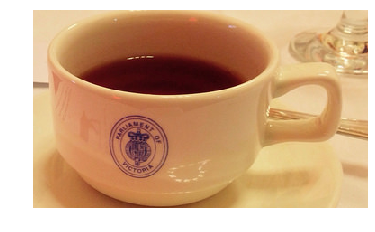

In [9]:
if __name__ == '__main__':
    app.run(debug=False)